# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn import metrics

import itertools

import warnings

warnings.filterwarnings('ignore')

# Lendo os Dados

In [2]:
df = pd.read_csv('dados_tcc.csv', sep=';')
df['ds'] = df['ds'].str.replace('/', '-')
df['ds'] = pd.to_datetime(df['ds'], format='%d-%m-%Y')
df

,ds,y
0,2015-01-31,642
1,2015-02-28,590
2,2015-03-31,849
3,2015-04-30,1271
4,2015-05-31,1585
...,...,...
74,2021-03-31,26373
75,2021-04-30,28130
76,2021-05-31,29576
77,2021-06-30,30588


# Prophet Simples

In [3]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [4]:
forecast = model.predict(df)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-31,1122.225350,-1649.934845,1751.123337,1122.225350,1122.225350,-1104.465903,-1104.465903,-1104.465903,-1104.465903,-1104.465903,-1104.465903,0.0,0.0,0.0,17.759447
1,2015-02-28,1243.593021,-2741.239798,484.584471,1243.593021,1243.593021,-2255.387980,-2255.387980,-2255.387980,-2255.387980,-2255.387980,-2255.387980,0.0,0.0,0.0,-1011.794960
2,2015-03-31,1377.964370,-1739.800040,1417.022520,1377.964370,1377.964370,-1598.938938,-1598.938938,-1598.938938,-1598.938938,-1598.938938,-1598.938938,0.0,0.0,0.0,-220.974568
3,2015-04-30,1508.001159,-433.482316,2696.486470,1508.001159,1508.001159,-412.741082,-412.741082,-412.741082,-412.741082,-412.741082,-412.741082,0.0,0.0,0.0,1095.260077
4,2015-05-31,1642.372508,396.213943,3682.637588,1642.372508,1642.372508,440.682770,440.682770,440.682770,440.682770,440.682770,440.682770,0.0,0.0,0.0,2083.055278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2021-03-31,26404.318650,23709.228462,27032.588329,26404.318650,26404.318650,-1013.976872,-1013.976872,-1013.976872,-1013.976872,-1013.976872,-1013.976872,0.0,0.0,0.0,25390.341777
75,2021-04-30,26945.458247,24962.582463,28162.583737,26945.458247,26945.458247,-415.207369,-415.207369,-415.207369,-415.207369,-415.207369,-415.207369,0.0,0.0,0.0,26530.250878
76,2021-05-31,27504.635831,25863.180190,29019.421175,27504.635831,27504.635831,-60.857637,-60.857637,-60.857637,-60.857637,-60.857637,-60.857637,0.0,0.0,0.0,27443.778194
77,2021-06-30,28045.775428,26767.568130,30070.835292,28045.775428,28045.775428,278.772670,278.772670,278.772670,278.772670,278.772670,278.772670,0.0,0.0,0.0,28324.548098


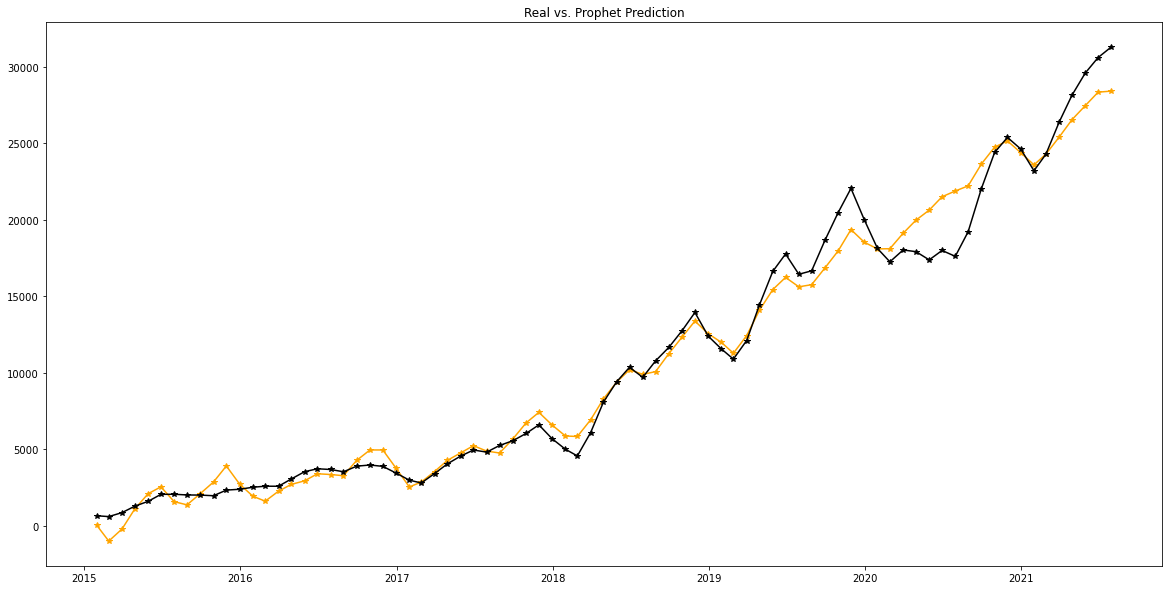

In [5]:
plt.figure(figsize=(20,10))
plt.title('Real vs. Prophet Prediction')

fig1 = plt.plot(forecast['ds'], forecast['yhat'], '*-', color='orange')
fig2 = plt.plot(df['ds'], df['y'], '*-', color='black')

plt.show()

In [6]:
mse = metrics.mean_squared_error(df['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(df['y'], forecast['yhat'], squared=False)
mad = metrics.mean_absolute_error(df['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(df['y'], forecast['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 1591095.32
      REQM: 1261.39
      MAD: 891.15
      MAPE: 17.12%
      


# Prophet Tunning

### Tunning

In [7]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [8]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [9]:
mape = []

for params in all_params:
    m = Prophet(**params).fit(df) 
    df_cv = cross_validation(m, initial='1460 days', horizon='60 days', period='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 29 forecasts with cutoffs between 2019-02-12 00:00:00 and 2021-06-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000229FB9B4F40>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 29 forecasts with cutoffs between 2019-02-12 00:00:00 and 2021-06-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000229FB97F250>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily

In [10]:
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
0,0.1,0.001,additive,0.115860
1,0.1,0.001,multiplicative,0.114673
2,0.1,0.010,additive,0.113262
3,0.1,0.010,multiplicative,0.113740
4,0.1,0.100,additive,0.113569
5,0.1,0.100,multiplicative,0.121190
6,0.1,1.000,additive,0.118344
7,0.1,1.000,multiplicative,0.156861
8,0.3,0.001,additive,0.123092
9,0.3,0.001,multiplicative,0.123170


In [11]:
best_params = all_params[np.argmin(mape)]
print(np.min(mape))
print(best_params)

0.10645920764226631
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


### Best Model

In [12]:
model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'])

In [13]:
model.fit(df)
forecast = model.predict(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


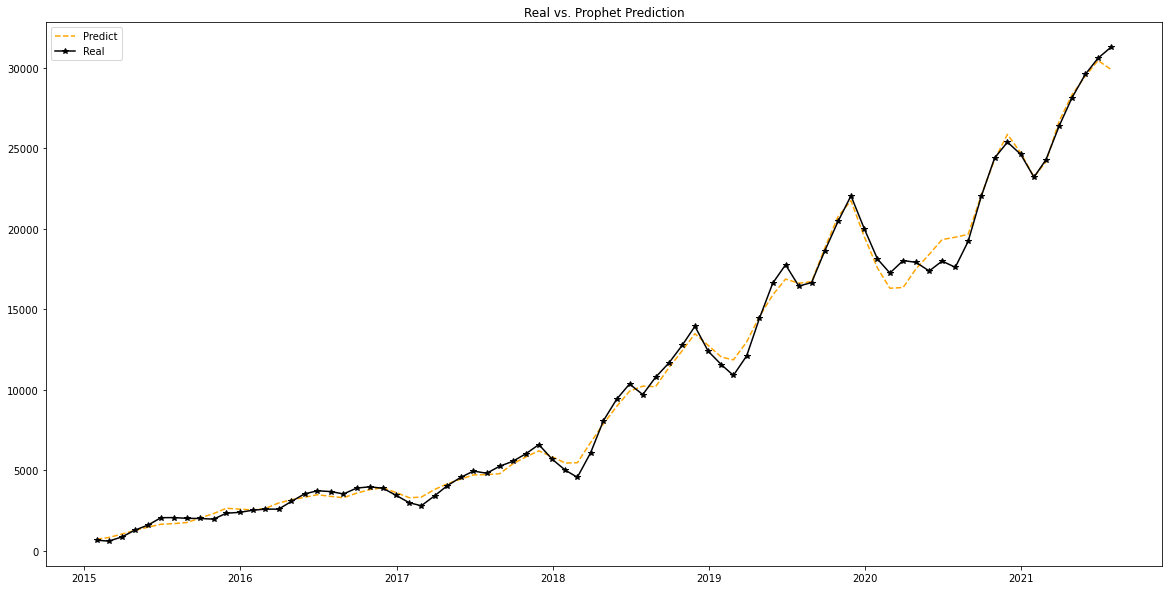

In [23]:
plt.figure(figsize=(20,10))
plt.title('Real vs. Prophet Prediction')

fig1 = plt.plot(forecast['ds'], forecast['yhat'], '--', color='orange', label='Predict')
fig2 = plt.plot(df['ds'], df['y'], '*-', color='black', label='Real')

plt.legend()
plt.show()

In [15]:
mse = metrics.mean_squared_error(df['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(df['y'], forecast['yhat'], squared=False)
mad = metrics.mean_absolute_error(df['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(df['y'], forecast['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 281809.75
      REQM: 530.86
      MAD: 384.41
      MAPE: 6.08%
      


# Alisamento Exponencial de Holt-Winters

In [16]:
hw = ExponentialSmoothing(df['y'], trend='add', seasonal='mul', seasonal_periods=6).fit()
hw_forecast = hw.predict(0,len(df)-1)
hw_forecast

0      1418.931494
1       398.714703
2       429.946920
3       901.793287
4      1589.250315
          ...     
74    27158.250487
75    28048.260194
76    29110.235269
77    29529.213740
78    29502.613115
Length: 79, dtype: float64

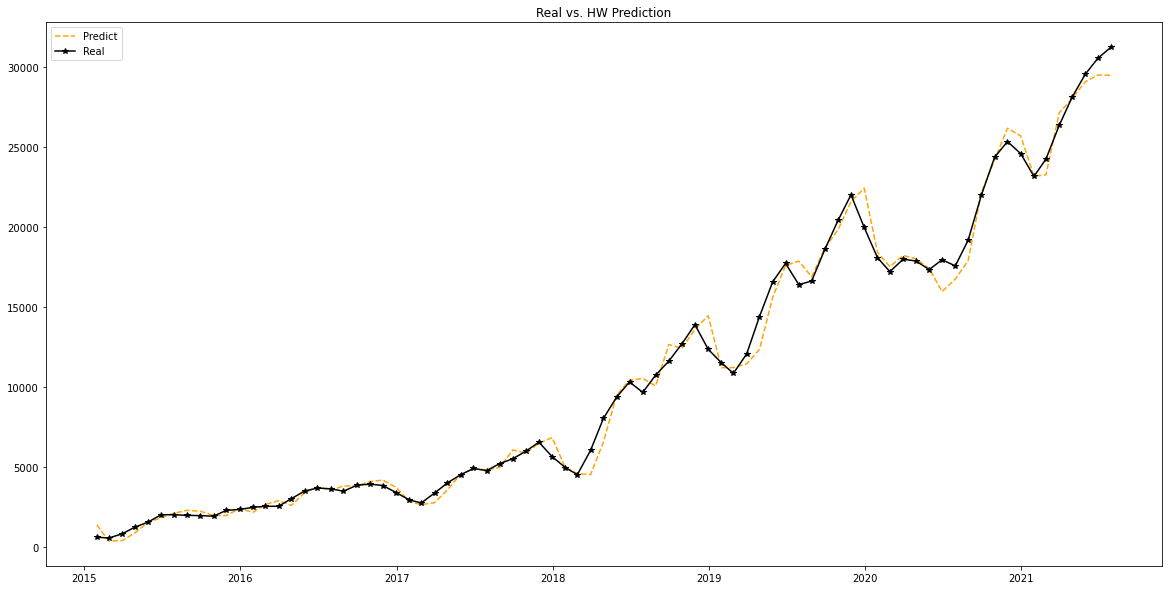

In [24]:
plt.figure(figsize=(20,10))
plt.title('Real vs. HW Prediction')

fig1 = plt.plot(df['ds'], hw_forecast, '--', color='orange', label='Predict')
fig2 = plt.plot(df['ds'], df['y'], '*-', color='black', label='Real')

plt.legend()
plt.show()

In [18]:
mse = metrics.mean_squared_error(df['y'], hw_forecast)
rmse = metrics.mean_squared_error(df['y'], hw_forecast, squared=False)
mad = metrics.mean_absolute_error(df['y'], hw_forecast)
mape = metrics.mean_absolute_percentage_error(df['y'], hw_forecast)

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 568521.4
      REQM: 754.0
      MAD: 508.19
      MAPE: 8.42%
      
